# Neural Symbolic Learner# NeuralSymbolic - Demo

## Dependencies

In [ ]:
!pip install keras-rectified-adam keras.utils tqdm numpy pandas scikit-learn tensorflow matplotlib

In [ ]:
pip install --upgrade tensorflow

In [ ]:
import tqdm
import numpy as np
import pandas as pd
from sklearn.model_selection import LeaveOneOut
import keras
from tensorflow.keras.models import Sequential
from keras.models import Sequential, Model
from keras.layers import Dense, Input, concatenate
from keras.losses import binary_crossentropy
from keras.utils import plot_model
from keras_radam import RAdam
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')


In [ ]:
from tensorflow.keras import backend as K
import tensorflow as tf
import numpy as np
import random
import os

seed_value = 0

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
os.environ["PYTHONHASHSEED"] = str(seed_value)

# 2. Set `python` built-in pseudo-random generator at a fixed value
random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)

# 4. Set `tensorflow` pseudo-random generator at a fixed value
tf.random.set_seed(seed_value)

# 5. Configure a new global `tensorflow` session
session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)


## Import Data from CSV

In [ ]:
# path to the data
#path = "trains-uptated.csv" # Para utilizar o arquivo com 100 trens (2.2)
path = "trains-uptated10.csv" # Para utilizar o arquivo com 10 trens (2.1)
str_att = {
    "length": ["short", "long"],
    "shape": [
        "closedblopnrect",
        "closedtrap",
        "closedrect",
        "closedushaped",
        "dblopnrect",
        "ellipse",
        "hexagon",
        "jaggedrect",
        "openrect",
        "opentrap",
        "slopetopdblopnrect",
        "slopetoprect",
        "slopetoptrap",
        "slopetopushaped",
        "ushaped",
    ],
    "load_shape": ["circlelod", "hexagonlod", "rectanglod", "trianglod"],
    "Class_attribute": ["west", "east"],
}


def read_data(path=path):
    df = pd.read_csv(path, sep=",")

    # Mapeia os atributos categóricos para valores numéricos
    for k in df.columns:
        for att in str_att:
            if k.startswith(att):
                df[k] = df[k].apply(lambda x: str_att[att].index(x) if x in str_att[att] else x)

    # Substitui valores especiais por números
    df.replace({"\\0": 0, "None": -1}, inplace=True)

    # Converte todas as colunas para numéricas, forçando erros para NaN e então preenchendo
    df = df.apply(pd.to_numeric, errors='coerce').fillna(-1)

    return df



df = read_data()
df


,Number_of_cars,Number_of_different_loads,num_wheels1,length1,shape1,num_loads1,load_shape1,num_wheels2,length2,shape2,...,Rectangle_next_to_triangle,Rectangle_next_to_hexagon,Rectangle_next_to_circle,Triangle_next_to_triangle,Triangle_next_to_hexagon,Triangle_next_to_circle,Hexagon_next_to_hexagon,Hexagon_next_to_circle,Circle_next_to_circle,Class_attribute
0,4,3,2,0,9,2,0,2,0,14,...,1,0,0,0,0,1,0,0,0,1
1,4,2,2,0,9,1,3,2,0,8,...,0,0,0,1,0,1,0,0,0,1
2,5,2,2,0,8,1,3,2,0,8,...,0,0,0,1,0,1,0,0,1,1
3,5,2,2,0,11,1,2,2,0,14,...,0,0,1,0,0,0,0,0,1,1
4,5,2,2,0,2,1,3,2,0,9,...,0,0,0,0,0,1,0,0,0,0
5,4,3,2,0,8,1,0,2,0,9,...,1,0,0,0,0,1,0,0,0,0
6,4,2,2,0,4,1,0,3,1,2,...,0,0,0,0,0,0,0,1,0,0
7,5,4,2,0,8,1,2,3,1,7,...,1,0,0,0,0,1,0,0,0,0
8,5,2,2,0,14,1,2,2,0,9,...,1,0,0,1,0,0,0,0,0,1
9,5,2,2,0,8,1,2,2,0,8,...,0,0,1,0,0,0,0,0,0,0


## Question 1.


In [ ]:
df = read_data()
Y = np.array(df.pop('Class_attribute'))
X = np.array(df)

### Akin Propositionalization Model

In [ ]:
# define model
def model_1():
    model = Sequential(
        [
            Dense(32, activation=tf.nn.relu, input_shape=(len(df.keys()),)),
            Dense(1, activation=tf.nn.sigmoid),
        ]
    )
    model.compile(
        loss='binary_crossentropy', optimizer='adam', metrics=["mse", "binary_accuracy"]
    )
    return model


es = keras.callbacks.EarlyStopping(
    monitor="val_loss", min_delta=0, patience=1000, verbose=0
)

model = model_1()
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,089 (4.25 KB)

 Trainable params: 1,089 (4.25 KB)

 Non-trainable params: 0 (0.00 B)

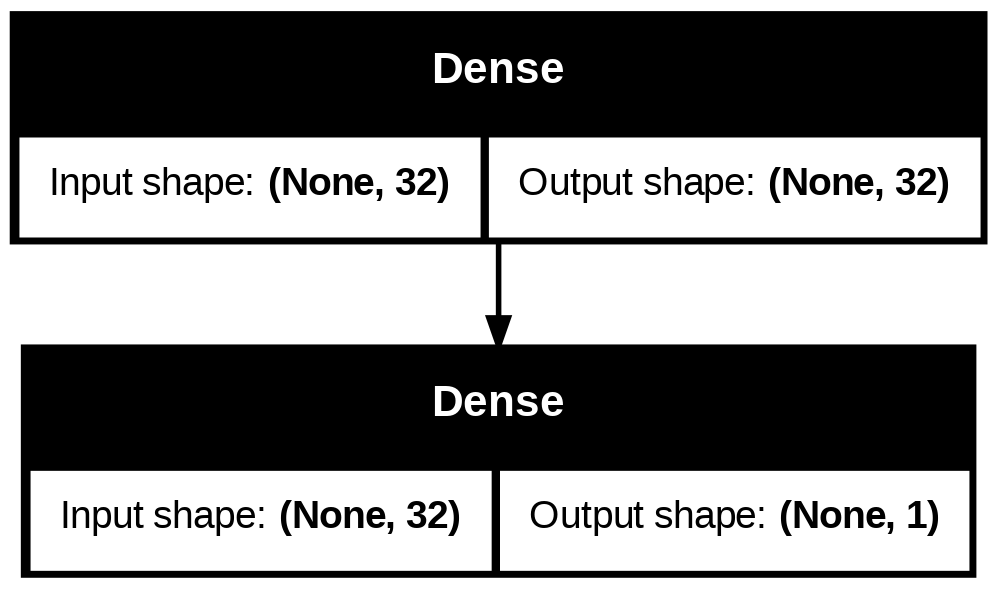

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=False)

### Train

Questão 1. a)

In [ ]:
from sklearn.model_selection import train_test_split, KFold
import numpy as np
import tqdm


# Inicializando dicionários e listas
hists = dict()
question_1_names = ["Fold", "Output of flat network", "Desired output", "Class"]
question_1 = {name: [] for name in question_1_names}
# Separar os dados em treino e teste
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.30, random_state=42)

# Inicializar o modelo e treinar
model = model_1()
hist = model.fit(
    np.array(X_train, dtype=float),
    np.array(Y_train, dtype=float),
    validation_data=(np.array(X_test, dtype=float), np.array(Y_test, dtype=float)),
    epochs=1000,
    verbose=0,
)

# Armazenar os resultados
hists = hist
question_1 = {
    "Train": [0],  # Como agora você tem apenas um conjunto de treino, adicionamos 0
    "Output of flat network": model.predict(np.array(X_test, dtype=float)).tolist(),
    "Desired output": np.array(Y_test, dtype=float).tolist(),
    "Class": [str_att["Class_attribute"][int(y)] for y in Y_test]
}

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


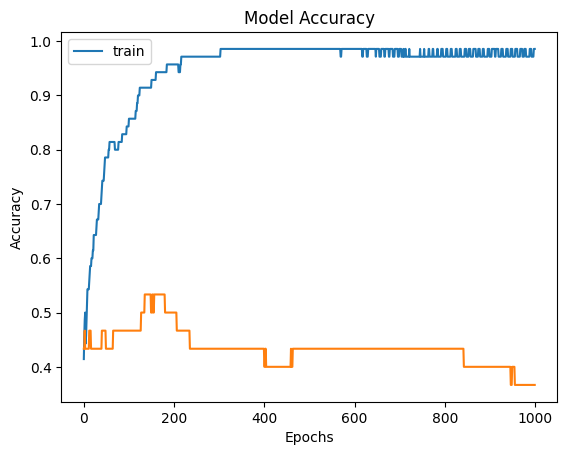

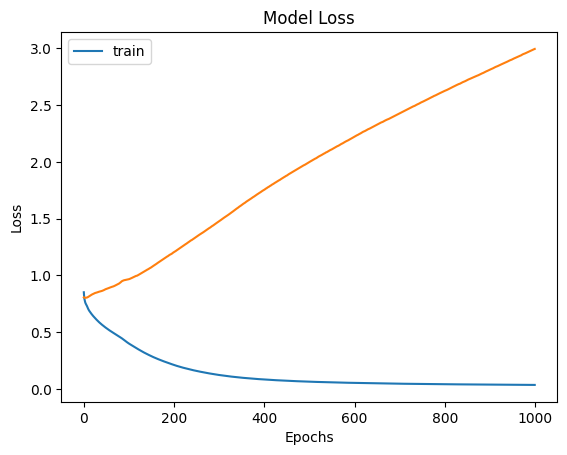

In [ ]:
plt.plot(hist.history['binary_accuracy'], c='tab:blue')
plt.plot(hist.history['val_binary_accuracy'], c='tab:orange')
plt.title("Model Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train'], loc='upper left')
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'], c='tab:orange')
plt.title("Model Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train'], loc='upper left')
plt.show()

Results

Questão 1. b)

In [ ]:
from sklearn.model_selection import KFold
import numpy as np
import tqdm

# Definindo o número de folds
n_splits = 5  # ou outro número que você desejar

# Inicializando o KFold com random_state
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Inicializando dicionários e listas
hists = dict()
question_1_names = ["Fold", "Output of flat network", "Desired output", "Class"]
question_1 = {name: [] for name in question_1_names}

# Loop sobre os folds

#1.2.b
for i, (train_index, test_index) in tqdm.tqdm(enumerate(kf.split(X)), total=n_splits):
    x_train, x_test = np.array(X[train_index], dtype=float), np.array(X[test_index], dtype=float)
    y_train, y_test = np.array(Y[train_index], dtype=float), np.array(Y[test_index], dtype=float)

    # Criação e treinamento do modelo
    model = model_1()
    hist = model.fit(
        x_train,
        y_train,
        validation_data=[x_test, y_test],
        epochs=1000,
        verbose=0,
    )
    hists[i] = hist

    # Armazenamento dos resultados
    question_1["Fold"].append(i)
    # Assumindo que y_test é uma array e pegando o primeiro valor
    y_test_value = y_test[0] if len(y_test) > 0 else None
    question_1["Output of flat network"].append(model.predict(x_test)[0][0])
    question_1["Desired output"].append(y_test_value)
    # Convertendo o valor de y_test para o índice
    class_label = str_att["Class_attribute"][int(y_test_value)] if y_test_value is not None else None
    question_1["Class"].append(class_label)




  0%|          | 0/5 [00:00<?, ?it/s]WARNING:tensorflow:5 out of the last 5 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x7a7841fc6950> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 20%|██        | 1/5 [01:13<04:54, 73.52s/it]WARNING:tensorflow:6 out of the last 6 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x7a7841d3e290> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 40%|████      | 2/5 [02:29<03:44, 74.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 60%|██████    | 3/5 [03:41<02:27, 73.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 80%|████████  | 4/5 [04:56<01:14, 74.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


100%|██████████| 5/5 [06:10<00:00, 74.17s/it]


In [ ]:
# Verificar alguns exemplos de históricos de treinamento
for key in list(hists.keys())[:3]:  # Mostrar os três primeiros
    print(f"Histórico para teste {key}: {hists[key].history}")

Histórico para teste 0: {'binary_accuracy': [0.5249999761581421, 0.574999988079071, 0.5, 0.48750001192092896, 0.5249999761581421, 0.512499988079071, 0.5249999761581421, 0.574999988079071, 0.574999988079071, 0.5874999761581421, 0.6000000238418579, 0.612500011920929, 0.625, 0.637499988079071, 0.625, 0.625, 0.6499999761581421, 0.6625000238418579, 0.6625000238418579, 0.675000011920929, 0.6625000238418579, 0.6625000238418579, 0.6625000238418579, 0.675000011920929, 0.675000011920929, 0.6625000238418579, 0.675000011920929, 0.6625000238418579, 0.6625000238418579, 0.6625000238418579, 0.6499999761581421, 0.6625000238418579, 0.6625000238418579, 0.6625000238418579, 0.6625000238418579, 0.6625000238418579, 0.675000011920929, 0.675000011920929, 0.675000011920929, 0.675000011920929, 0.699999988079071, 0.7124999761581421, 0.7124999761581421, 0.7250000238418579, 0.7250000238418579, 0.737500011920929, 0.75, 0.75, 0.75, 0.7749999761581421, 0.7875000238418579, 0.7875000238418579, 0.800000011920929, 0.80000

### Results

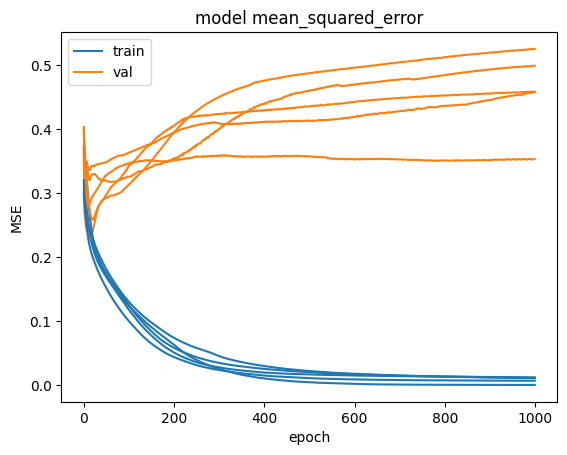

In [ ]:
for i, history in enumerate(hists.values()):
    plt.plot(history.history['mse'], c='tab:blue')
    plt.plot(history.history['val_mse'], c='tab:orange')

plt.title('model mean_squared_error')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


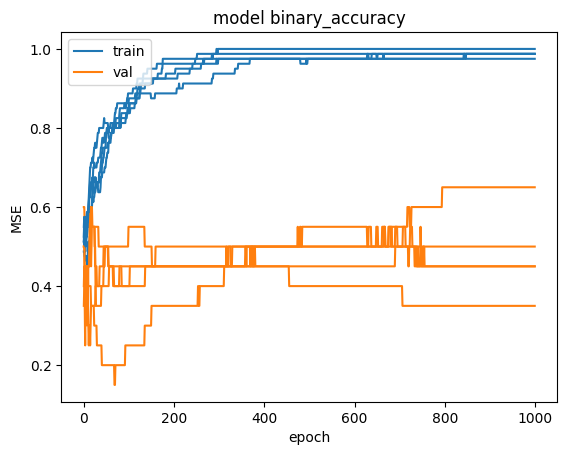

In [ ]:
for i, history in enumerate(hists.values()):
    plt.plot(history.history['binary_accuracy'], c='tab:blue')
    plt.plot(history.history['val_binary_accuracy'], c='tab:orange')

plt.title('model binary_accuracy')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [ ]:
train_1 = pd.DataFrame.from_dict(question_1).round(2)
train_1


## Question 2.


### LTNTorch


In [ ]:
def model_2():
    # features
    t = Input(shape=(1,), name="t")
    c = Input(shape=(1,), name="c")
    w = Input(shape=(1,), name="w")
    l = Input(shape=(1,), name="l")
    s = Input(shape=(1,), name="s")
    nc = Input(shape=(1,), name="nc")
    ls = Input(shape=(1,), name="ls")
    nl = Input(shape=(1,), name="nl")
    ncl = Input(shape=(1,), name="ncl")
    x_crc = Input(shape=(1,), name="x_crc")
    x_hex = Input(shape=(1,), name="x_hex")
    x_rec = Input(shape=(1,), name="x_rec")
    x_tri = Input(shape=(1,), name="x_tri")

    # num_cars(t,nc)
    num_cars_ = concatenate([t, nc])
    num_cars_ = Dense(20, activation="relu")(num_cars_)
    num_cars = Dense(1, activation="sigmoid", name="num_cars")(num_cars_)
    num_cars = Model(inputs=[t, nc], outputs=num_cars)

    # num_loads(t,nl)
    num_loads_ = concatenate([t, nl])
    num_loads_ = Dense(20, activation="relu")(num_loads_)
    num_loads = Dense(1, activation="sigmoid", name="num_loads")(num_loads_)
    num_loads = Model(inputs=[t, nl], outputs=num_loads)

    # num_wheels(t,c,w)
    num_wheels_ = concatenate([t, c, w])
    num_wheels_ = Dense(20, activation="relu")(num_wheels_)
    num_wheels = Dense(1, activation="sigmoid", name="num_wheels")(num_wheels_)
    num_wheels = Model(inputs=[t, c, w], outputs=num_wheels)

    # length(t,c,l)
    length_ = concatenate([t, c, l])
    length_ = Dense(20, activation="relu")(length_)
    length = Dense(1, activation="sigmoid", name="length")(length_)
    length = Model(inputs=[t, c, l], outputs=length)

    # shape(t,c,s)
    shape_ = concatenate([t, c, s])
    shape_ = Dense(20, activation="relu")(shape_)
    shape = Dense(1, activation="sigmoid", name="shape")(shape_)
    shape = Model(inputs=[t, c, s], outputs=shape)

    # num_car_loads(t,c,ncl)
    num_car_loads_ = concatenate([t, c, ncl])
    num_car_loads_ = Dense(20, activation="relu")(num_car_loads_)
    num_car_loads = Dense(1, activation="sigmoid", name="num_car_loads")(num_car_loads_)
    num_car_loads = Model(inputs=[t, c, ncl], outputs=num_car_loads)

    # load_shape(t,c,ls)
    load_shape_ = concatenate([t, c, ls])
    load_shape_ = Dense(20, activation="relu")(load_shape_)
    load_shape = Dense(1, activation="sigmoid", name="load_shape")(load_shape_)
    load_shape = Model(inputs=[t, c, ls], outputs=load_shape)

    # next_crc(t,c,x)
    next_crc_ = concatenate([t, c, x_crc])
    next_crc_ = Dense(20, activation="relu")(next_crc_)
    next_crc = Dense(1, activation="sigmoid", name="next_crc")(next_crc_)
    next_crc = Model(inputs=[t, c, x_crc], outputs=next_crc)

    # next_hex_(t,c,x)
    next_hex_ = concatenate([t, c, x_hex])
    next_hex_ = Dense(20, activation="relu")(next_hex_)
    next_hex = Dense(1, activation="sigmoid", name="next_hex")(next_hex_)
    next_hex = Model(inputs=[t, c, x_hex], outputs=next_hex)

    # next_rec(t,c,x)
    next_rec_ = concatenate([t, c, x_rec])
    next_rec_ = Dense(20, activation="relu")(next_rec_)
    next_rec = Dense(1, activation="sigmoid", name="next_rec")(next_rec_)
    next_rec = Model(inputs=[t, c, x_rec], outputs=next_rec)

    # next_tri(t,c,x)
    next_tri_ = concatenate([t, c, x_tri])
    next_tri_ = Dense(20, activation="relu")(next_tri_)
    next_tri = Dense(1, activation="sigmoid", name="next_tri")(next_tri_)
    next_tri = Model(inputs=[t, c, x_tri], outputs=next_tri)

    # east
    east = concatenate(
        [
            num_cars_,
            num_loads_,
            num_wheels_,
            length_,
            shape_,
            num_car_loads_,
            load_shape_,
            next_crc_,
            next_hex_,
            next_rec_,
            next_tri_,
        ]
    )
    east = Dense(3, activation="relu")(east)
    east = Dense(1, activation="sigmoid", name="east")(east)
    east = Model(
        inputs=[t, c, w, l, s, nc, ls, nl, ncl, x_crc, x_hex, x_rec, x_tri],
        outputs=east,
    )

    # metanet
    metanet = Model(
        inputs=east.inputs,
        outputs=[
            num_cars.output,
            num_loads.output,
            num_wheels.output,
            length.output,
            shape.output,
            num_car_loads.output,
            load_shape.output,
            next_crc.output,
            next_hex.output,
            next_rec.output,
            next_tri.output,
            east.output,
        ],
    )

    # rules
    rules = {
        "num_cars": num_cars,
        "num_loads": num_loads,
        "num_wheels": num_wheels,
        "length": length,
        "shape": shape,
        "num_car_loads": num_car_loads,
        "load_shape": load_shape,
        "next_crc": next_crc,
        "next_hex": next_hex,
        "next_rec": next_rec,
        "next_tri": next_tri,
    }

    return metanet, east, rules


metanet, east, rules = model_2()
metanet.summary()


Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ t (InputLayer)            │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ nc (InputLayer)           │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ nl (InputLayer)           │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ c (InputLayer)            │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ w (InputLayer)            │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ l (InputLayer)            │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ s (InputLayer)            │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ ncl (InputLayer)          │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ ls (InputLayer)           │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ x_crc (InputLayer)        │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ x_hex (InputLayer)        │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ x_rec (InputLayer)        │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ x_tri (InputLayer)        │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 2)              │              0 │ t[0][0], nc[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 2)              │              0 │ t[0][0], nl[0][0]      │
│ (Concatenate)             │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_2             │ (None, 3)              │              0 │ t[0][0], c[0][0],      │
│ (Concatenate)             │                        │                │ w[0][0]                │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_3             │ (None, 3)              │              0 │ t[0][0], c[0][0],      │
│ (Concatenate)             │                        │                │ l[0][0]                │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_4             │ (None, 3)              │              0 │ t[0][0], c[0][0],      │
│ (Concatenate)        

 Total params: 1,738 (6.79 KB)

 Trainable params: 1,738 (6.79 KB)

 Non-trainable params: 0 (0.00 B)

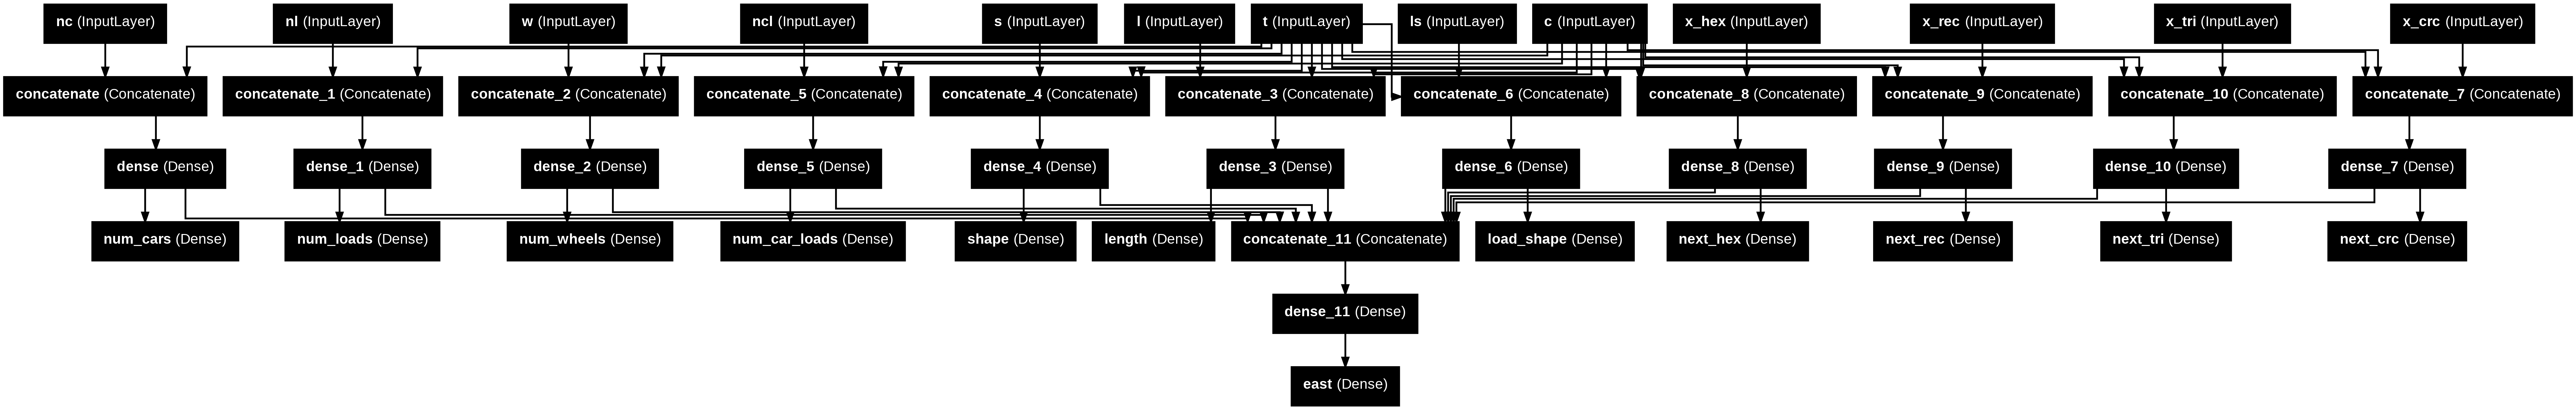

In [ ]:
plot_model(metanet, show_shapes=False, show_layer_names=True)

### Data Augmentation

In [ ]:
df = read_data()
cols = [
    [
        c
        for c in df.columns
        if not (str.isdigit(c[-1])) or (str.isdigit(c[-1]) and int(c[-1]) == n)
    ]
    for n in range(1, 5)
]

data = [df[col] for col in cols]
for c, df in enumerate(data):
    df.columns = [
        name if not str.isdigit(name[-1]) else name[:-1] for name in df.columns
    ]
    df["car"] = c + 1

data = pd.concat(data)
data.reset_index(level=0, inplace=True)
data["train"] = data.pop("index")
data.T[5]
data

,Number_of_cars,Number_of_different_loads,num_wheels,length,shape,num_loads,load_shape,Rectangle_next_to_rectangle,Rectangle_next_to_triangle,Rectangle_next_to_hexagon,Rectangle_next_to_circle,Triangle_next_to_triangle,Triangle_next_to_hexagon,Triangle_next_to_circle,Hexagon_next_to_hexagon,Hexagon_next_to_circle,Circle_next_to_circle,Class_attribute,car,train
0,4,3,2.0,0.0,9.0,2.0,0.0,0,1,0,0,0,0,1,0,0,0,1,1,0
1,4,2,2.0,0.0,9.0,1.0,3.0,0,0,0,0,1,0,1,0,0,0,1,1,1
2,5,2,2.0,0.0,8.0,1.0,3.0,0,0,0,0,1,0,1,0,0,1,1,1,2
3,5,2,2.0,0.0,11.0,1.0,2.0,0,0,0,1,0,0,0,0,0,1,1,1,3
4,5,2,2.0,0.0,2.0,1.0,3.0,0,0,0,0,0,0,1,0,0,0,0,1,4
5,4,3,2.0,0.0,8.0,1.0,0.0,0,1,0,0,0,0,1,0,0,0,0,1,5
6,4,2,2.0,0.0,4.0,1.0,0.0,0,0,0,0,0,0,0,0,1,0,0,1,6
7,5,4,2.0,0.0,8.0,1.0,2.0,0,1,0,0,0,0,1,0,0,0,0,1,7
8,5,2,2.0,0.0,14.0,1.0,2.0,0,1,0,0,1,0,0,0,0,0,1,1,8
9,5,2,2.0,0.0,8.0,1.0,2.0,0,0,0,1,0,0,0,0,0,0,0,1,9


### Train

In [ ]:
def sort_inputs(X):
    t = X["train"].T
    c = X["car"].T
    w = X["num_wheels"].T
    l = X["length"].T
    s = X["shape"].T
    nc = X["Number_of_cars"].T
    ls = X["load_shape"].T
    nl = X["Number_of_different_loads"].T
    ncl = X["num_loads"].T
    x_crc = np.sum(X[[col for col in X if col.endswith("circle")]], axis=1).T
    x_hex = np.sum(X[[col for col in X if col.endswith("hexagon")]], axis=1).T
    x_rec = np.sum(X[[col for col in X if col.endswith("rectangle")]], axis=1).T
    x_tri = np.sum(X[[col for col in X if col.endswith("triangle")]], axis=1).T

    return [t, c, w, l, s, nc, ls, nl, ncl, x_crc, x_hex, x_rec, x_tri]


def split(data, val_train):
    x_train = data.query(f"train != {val_train}")
    x_test = data.query(f"train == {val_train}")
    y_train = np.array(x_train.pop("Class_attribute"))
    y_test = np.array(x_test.pop("Class_attribute"))
    x_train = sort_inputs(x_train)
    x_test = sort_inputs(x_test)

    return x_train, x_test, y_train, y_test


In [ ]:
hists = dict()
question_2_names = [
    "Train",
    "Output of flat network",
    "Desired output",
    "Class",
]
question_2 = {name: [] for name in question_2_names}

for validation_i in tqdm.tqdm(range(0, 5)):
    x_train, x_test, y_train, y_test = split(data, validation_i)
    metanet, east, rules = model_2()

    x_train = [np.array(x, dtype=float) for x in x_train]
    y_train = np.asarray(y_train, dtype=float)
    x_test = [np.asarray(x, dtype=float) for x in x_test]
    y_test = np.asarray(y_test, dtype=float)

    east.compile(
        loss=binary_crossentropy, optimizer='adam', metrics=["mse", "binary_accuracy"]
    )
    hist = east.fit(
        x_train,
        y_train,
        validation_data=[x_test, y_test],
        epochs=1000,
        verbose=0,
    )
    hists[validation_i] = hist

    question_2["Train"].append(validation_i)
    question_2["Output of flat network"].append(east.predict(x_test)[0][0])
    question_2["Desired output"].append(y_test[0])
    question_2["Class"].append(str_att["Class_attribute"][int(y_test[0])])


  0%|          | 0/5 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 20%|██        | 1/5 [01:54<07:38, 114.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 40%|████      | 2/5 [03:57<05:59, 119.77s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 60%|██████    | 3/5 [05:53<03:55, 117.99s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 80%|████████  | 4/5 [07:47<01:56, 116.39s/it]WARNING:tensorflow:5 out of the last 5 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x7e92b8d829e0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


100%|██████████| 5/5 [09:41<00:00, 116.22s/it]


### Results

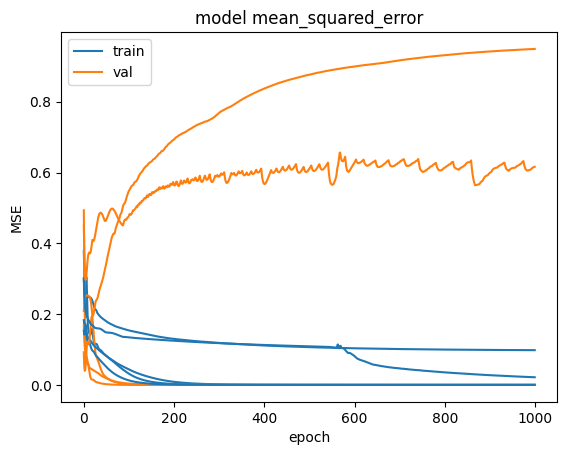

In [ ]:
for i, history in enumerate(hists.values()):
    plt.plot(history.history['mse'], c='tab:blue')
    plt.plot(history.history['val_mse'], c='tab:orange')

plt.title('model mean_squared_error')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


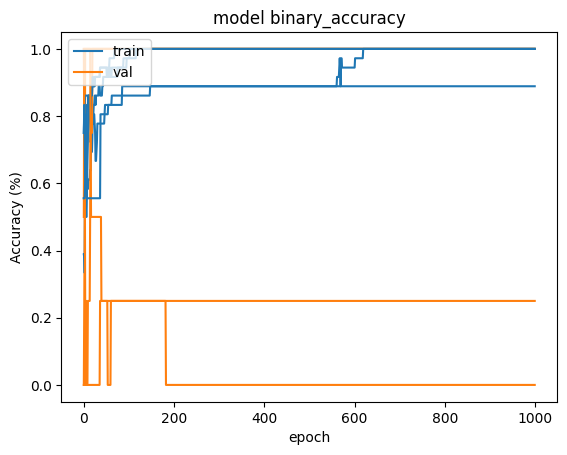

In [ ]:
for i, history in enumerate(hists.values()):
    plt.plot(history.history['binary_accuracy'], c='tab:blue')
    plt.plot(history.history['val_binary_accuracy'], c='tab:orange')

plt.title('model binary_accuracy')
plt.ylabel('Accuracy (%)')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [ ]:
t2 = pd.DataFrame.from_dict(question_2).round(2)
t2["Cars Accuracy"] = [hists[i].history["binary_accuracy"][-1] for i in range(0, 5)]
t2 = t2.reindex(
    columns=[
        "Train",
        "Cars Accuracy",
        "Output of flat network",
        "Desired output",
        "Class",
    ]
)
t2


,Train,Cars Accuracy,Output of flat network,Desired output,Class
0,0,1.000000,1.00,1.0,east
1,1,0.888889,1.00,1.0,east
2,2,1.000000,1.00,1.0,east
3,3,1.000000,0.00,1.0,east
4,4,1.000000,0.22,0.0,west
